In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Comet Import and Setup

In [5]:
#comet imports
from comet_ml import Experiment

In [9]:
# Import comet_ml at the top of your file, before sklearn!
from comet_ml import Experiment
import os 

# Create an experiment with your api key
comet_exp = Experiment(
    api_key=os.environ.get('COMET_API_KEY'),  # don’t hardcode!!
    project_name="milestone_2",
    workspace="morph-e",
    log_code=True,
)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/morph-e/milestone-2/e1b25bbe6ebe466a807aec8d835db26c
COMET INFO:   Metrics:
COMET INFO:   Parameters:
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (5 MB)
COMET INFO:     installed packages       : 1
COMET INFO: ---------------------------
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/morph-e/milestone-2/7b31fdabd2264bacb15166b2be9f561e



# Imports

In [128]:
#classic
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import tempfile

#project imports
from ift6758.features.feature_engineering2 import SeasonDataSetTwo
from ift6758.metrics import plot_metrics
from ift6758.data.data_acquisition import Season
from ift6758.visualizations.simple_visualization import Utilities 

#sk-learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, auc)

#keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, preprocessing, activations



In [129]:
#misc
pd.set_option('display.max_columns', None)

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.filterwarnings("ignore")

# DATA LOADING

In [12]:
#year selection
train_years = [2015,2016,2017]
valid_years = [2018]
test_years=[2019]

In [13]:
train_dataset = SeasonDataSetTwo(train_years)
valid_dataset = SeasonDataSetTwo(valid_years)
train_df = train_dataset.get_features_2()
valid_df = valid_dataset.get_features_2()

File with all events already Exists, loading from ../ift6758/data/PICKLE//2015_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2015_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2016_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2016_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2017_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2017_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2018_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2018_period_info.pkl


In [14]:
test_data = SeasonDataSetTwo(test_years)
test_df = test_data.get_features_2()

File with all events already Exists, loading from ../ift6758/data/PICKLE//2019_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2019_period_info.pkl


# Split and shuffle

In [15]:
random.seed(42)

In [16]:
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)
valid_df = valid_df.sample(frac=1)

In [17]:
train_df.head()

,result.penaltySeverity,result.penaltyMinutes,gamePk,team.name,gamePeriod,coordinatesX,coordinatesY,shotType,emptyNet,result.strength.name,gameSeconds,shotDistance,shotAngle,isGoal,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,timeFromLastEvent,distanceFromLastEvent,rebound,speed,changeInShotAngle
207516,NaN,NaN,2017020583,Dallas Stars,1,-53.0,36.0,Slap Shot,0,NaN,506.0,50.911688,45.000000,0,Shot,-51.0,-20.0,22.0,56.035703,True,2.547077,36.869898
230814,NaN,NaN,2017020942,Pittsburgh Penguins,1,80.0,11.0,Backhand,0,NaN,1084.0,14.212670,-50.710593,0,Takeaway,14.0,-11.0,2.0,69.570109,False,34.785054,0.000000
166377,NaN,NaN,2017010033,Colorado Avalanche,2,54.0,19.0,Slap Shot,0,NaN,741.0,39.824616,-28.495639,0,Faceoff,-69.0,22.0,21.0,123.036580,False,5.858885,0.000000
11220,NaN,NaN,2015020189,Minnesota Wild,2,72.0,-21.0,Snap Shot,0,NaN,549.0,27.018512,51.009006,0,Faceoff,69.0,-22.0,7.0,3.162278,False,0.451754,0.000000
60808,NaN,NaN,2015021011,Edmonton Oilers,2,-51.0,13.0,Wrist Shot,0,NaN,785.0,40.162171,18.886087,0,Blocked Shot,-57.0,8.0,8.0,7.810250,False,0.976281,0.000000


# Preprocessing

In [18]:
features = ['gameSeconds','timeFromLastEvent','gamePeriod','shotType', 'shotAngle', 'shotDistance','distanceFromLastEvent', 'rebound','speed','changeInShotAngle']
label = ['isGoal']

In [19]:
train_df[features].isna().any()
valid_df[features].isna().any()
valid_df[features].isna().any()

gameSeconds              False
timeFromLastEvent        False
gamePeriod               False
shotType                  True
shotAngle                 True
shotDistance              True
distanceFromLastEvent     True
rebound                  False
speed                     True
changeInShotAngle        False
dtype: bool

In [20]:
#replace inf with nan
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [21]:
#drop rows with nan
train_df = train_df[train_df['shotType'].notna()]
valid_df = train_df[train_df['shotType'].notna()]
test_df = train_df[train_df['shotType'].notna()]

train_df = train_df[train_df['shotAngle'].notna()]
valid_df = train_df[train_df['shotAngle'].notna()]
test_df = train_df[train_df['shotAngle'].notna()]

train_df = train_df[train_df['shotDistance'].notna()]
valid_df = train_df[train_df['shotDistance'].notna()]
test_df = train_df[train_df['shotDistance'].notna()]

train_df = train_df[train_df['speed'].notna()]
valid_df = train_df[train_df['speed'].notna()]
test_df = train_df[train_df['speed'].notna()]

train_df = train_df[train_df['changeInShotAngle'].notna()]
valid_df = train_df[train_df['changeInShotAngle'].notna()]
test_df = train_df[train_df['changeInShotAngle'].notna()]

train_df = train_df[train_df['distanceFromLastEvent'].notna()]
valid_df = train_df[train_df['distanceFromLastEvent'].notna()]
test_df = train_df[train_df['distanceFromLastEvent'].notna()]

In [22]:
train_df[features].isna().any()
valid_df[features].isna().any()
valid_df[features].isna().any()

gameSeconds              False
timeFromLastEvent        False
gamePeriod               False
shotType                 False
shotAngle                False
shotDistance             False
distanceFromLastEvent    False
rebound                  False
speed                    False
changeInShotAngle        False
dtype: bool

In [23]:
X_train = train_df[features]
y_train = train_df[label]

X_valid = valid_df[features]
y_valid = valid_df[label]

X_test = test_df[features]
y_test = test_df[label]

X_train, y_train

(        gameSeconds  timeFromLastEvent  gamePeriod    shotType  shotAngle  \
 207516        506.0               22.0           1   Slap Shot  45.000000   
 230814       1084.0                2.0           1    Backhand -50.710593   
 166377        741.0               21.0           2   Slap Shot -28.495639   
 11220         549.0                7.0           2   Snap Shot  51.009006   
 60808         785.0                8.0           2  Wrist Shot  18.886087   
 ...             ...                ...         ...         ...        ...   
 165806         24.0                5.0           1  Wrist Shot -16.699244   
 232334        390.0               36.0           2    Backhand  63.434949   
 174466        640.0               15.0           3  Wrist Shot  46.169139   
 243907        181.0               24.0           3   Slap Shot -22.190289   
 150836        470.0               28.0           3   Snap Shot  30.963757   
 
         shotDistance  distanceFromLastEvent  rebound      spe

### One hot encoding for shot type

In [24]:
dum_train = pd.get_dummies(X_train['shotType'], prefix='Shot',dtype=int)
dum_valid = pd.get_dummies(X_valid['shotType'], prefix='Shot',dtype=int)
dum_test = pd.get_dummies(X_test['shotType'], prefix='Shot',dtype=int)

In [25]:
X_train = pd.concat([X_train, dum_train], axis=1)
X_valid = pd.concat([X_valid, dum_valid], axis=1)
X_test = pd.concat([X_test, dum_test], axis=1)

In [26]:
#check if no nans
X_train.isna().any(), X_valid.isna().any(), X_test.isna().any()

(gameSeconds              False
 timeFromLastEvent        False
 gamePeriod               False
 shotType                 False
 shotAngle                False
 shotDistance             False
 distanceFromLastEvent    False
 rebound                  False
 speed                    False
 changeInShotAngle        False
 Shot_Backhand            False
 Shot_Deflected           False
 Shot_Slap Shot           False
 Shot_Snap Shot           False
 Shot_Tip-In              False
 Shot_Wrap-around         False
 Shot_Wrist Shot          False
 dtype: bool,
 gameSeconds              False
 timeFromLastEvent        False
 gamePeriod               False
 shotType                 False
 shotAngle                False
 shotDistance             False
 distanceFromLastEvent    False
 rebound                  False
 speed                    False
 changeInShotAngle        False
 Shot_Backhand            False
 Shot_Deflected           False
 Shot_Slap Shot           False
 Shot_Snap Shot           

In [27]:
X_train = X_train.drop(columns='shotType')
X_valid = X_valid.drop(columns='shotType')
X_test = X_test.drop(columns='shotType')
X_train.head()

,gameSeconds,timeFromLastEvent,gamePeriod,shotAngle,shotDistance,distanceFromLastEvent,rebound,speed,changeInShotAngle,Shot_Backhand,Shot_Deflected,Shot_Slap Shot,Shot_Snap Shot,Shot_Tip-In,Shot_Wrap-around,Shot_Wrist Shot
207516,506.0,22.0,1,45.000000,50.911688,56.035703,True,2.547077,36.869898,0,0,1,0,0,0,0
230814,1084.0,2.0,1,-50.710593,14.212670,69.570109,False,34.785054,0.000000,1,0,0,0,0,0,0
166377,741.0,21.0,2,-28.495639,39.824616,123.036580,False,5.858885,0.000000,0,0,1,0,0,0,0
11220,549.0,7.0,2,51.009006,27.018512,3.162278,False,0.451754,0.000000,0,0,0,1,0,0,0
60808,785.0,8.0,2,18.886087,40.162171,7.810250,False,0.976281,0.000000,0,0,0,0,0,0,1


## Change rebound to int

In [28]:
X_train['rebound'] = X_train['rebound'].astype(int)
X_valid['rebound'] = X_valid['rebound'].astype(int)
X_test['rebound'] = X_test['rebound'].astype(int)

## Normalize numerical columns

In [29]:
num = ['gameSeconds','timeFromLastEvent', 'shotAngle', 'shotDistance','distanceFromLastEvent','speed','changeInShotAngle']

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[num])

X_train[num] = scaler.transform(X_train[num])
X_valid[num] = scaler.transform(X_valid[num])
X_test[num] = scaler.transform(X_test[num])

In [31]:
X_train.head()

,gameSeconds,timeFromLastEvent,gamePeriod,shotAngle,shotDistance,distanceFromLastEvent,rebound,speed,changeInShotAngle,Shot_Backhand,Shot_Deflected,Shot_Slap Shot,Shot_Snap Shot,Shot_Tip-In,Shot_Wrap-around,Shot_Wrist Shot
207516,-0.252915,0.430416,1,1.216117,0.301291,-0.129391,1,-0.537092,1.435676,0,0,1,0,0,0,0
230814,1.407502,-0.916515,1,-1.421708,-0.804022,0.164040,0,2.651864,-0.362894,1,0,0,0,0,0,0
166377,0.422168,0.363069,2,-0.809455,-0.032633,1.323213,0,-0.209490,-0.362894,0,0,1,0,0,0,0
11220,-0.129389,-0.579782,2,1.381728,-0.418331,-1.275707,0,-0.744360,-0.362894,0,0,0,1,0,0,0
60808,0.548567,-0.512436,2,0.496406,-0.022466,-1.174937,0,-0.692474,-0.362894,0,0,0,0,0,0,1


# Imbalnced Data check

Based on the imbalanced data tutorial by tensorflow
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [32]:
y_train.value_counts()

isGoal
0         226058
1          22218
dtype: int64

In [100]:
neg, pos = np.bincount(y_train['isGoal'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 248276
    Positive: 22218 (8.95% of total)



### This means that only 10% of the data is goals -> unbalanced data 

# Neural Network with KERAS

In [161]:
# convert to tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [162]:
for inputs, targets in train_ds.take(2):
    print ('Data: {}, Target: {}'.format(inputs, targets))
    print()

Data: [-0.2529146   0.43041584  1.          1.21611705  0.30129105 -0.12939114
  1.         -0.53709172  1.43567554  0.          0.          1.
  0.          0.          0.          0.        ], Target: [0]

Data: [ 1.40750195 -0.91651499  1.         -1.42170849 -0.80402168  0.16403988
  0.          2.6518641  -0.36289432  1.          0.          0.
  0.          0.          0.          0.        ], Target: [0]



In [163]:
print(train_ds.cardinality().numpy())

248276


In [164]:
print(val_ds.cardinality().numpy())

248276


In [165]:
BATCH_SIZE = 512

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(BATCH_SIZE)

val_ds = val_ds.shuffle(buffer_size=1000)
val_ds = val_ds.batch(BATCH_SIZE)

for inputs, targets in train_ds.take(3):
    print('Data: ', inputs.numpy()[:3])
    print('Target: ', targets.numpy()[:3])
    print()

Data:  [[-0.68094586 -0.98386153  2.          1.94826141 -0.94635596 -0.79579132
   0.          1.71343389 -0.36289432  0.          0.          0.
   0.          0.          0.          1.        ]
 [ 0.05733625 -0.64712882  3.          1.03332207  0.61178753 -0.82348577
   0.         -0.39302642 -0.36289432  0.          0.          1.
   0.          0.          0.          0.        ]
 [ 1.56837276 -0.10835649  1.         -0.2240037   3.7775266   0.7371628
   0.         -0.11070657 -0.36289432  0.          0.          0.
   0.          0.          0.          1.        ]]
Target:  [[0]
 [0]
 [0]]

Data:  [[-1.47955451 -0.98386153  3.         -3.32432347 -0.98926177 -0.91011709
   1.          1.19180937  4.18255997  0.          0.          0.
   0.          0.          0.          1.        ]
 [-0.79010819 -0.51243574  1.          1.09488682 -0.95440624 -0.89731388
   0.         -0.53413764 -0.36289432  0.          0.          0.
   0.          1.          0.          0.        ]
 [ 1.

In [168]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [169]:
def build_model(metrics=METRICS, output_bias=None):
    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = keras.models.Sequential()
    
    #Input Layer
    model.add(layers.InputLayer(input_shape=(X_train.shape[-1],)))
    
    # first fc layer
    model.add(layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'))
    model.add(layers.AlphaDropout(0.1))

    model.add(layers.Dense(128, kernel_initializer='lecun_normal', activation='selu'))
    model.add(layers.AlphaDropout(0.1))
      
    model.add(layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'))
    model.add(layers.AlphaDropout(0.1))
    
    model.add(layers.Dense(32, kernel_initializer='lecun_normal', activation='selu'))
    model.add(layers.AlphaDropout(0.1))
    
    model.add(layers.Dense(16, kernel_initializer='lecun_normal', activation='selu'))
    model.add(layers.AlphaDropout(0.1))
    
    # Last fc layer 
    # We choose the activation method as a sigmoid to get an output ranging between [0, 1]
    model.add(layers.Dense(1, activation='sigmoid', bias_initializer=output_bias, name='target'))
    
    # Compile The model
    global LEARNING_RATE
    LEARNING_RATE= 1e-2

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss = keras.losses.BinaryCrossentropy(from_logits=False),
              metrics = METRICS)

    return model

In [170]:
#build model
model = build_model()

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 256)               4352      
                                                                 
 alpha_dropout (AlphaDropout  (None, 256)              0         
 )                                                               
                                                                 
 dense_42 (Dense)            (None, 128)               32896     
                                                                 
 alpha_dropout_1 (AlphaDropo  (None, 128)              0         
 ut)                                                             
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 alpha_dropout_2 (AlphaDropo  (None, 64)              

In [171]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    patience=10, 
    verbose=1, 
    mode='max',
    restore_best_weights=True)

EPOCHS = 50

In [172]:
history = model.fit(x=train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[stop_early])

Epoch 1/50
485/485 [==============================] - 11s 19ms/step - loss: 0.2920 - tp: 74.0000 - fp: 588.0000 - tn: 225470.0000 - fn: 22144.0000 - accuracy: 0.9084 - precision: 0.1118 - recall: 0.0033 - auc: 0.6668 - prc: 0.1509 - val_loss: 0.2837 - val_tp: 29.0000 - val_fp: 34.0000 - val_tn: 226024.0000 - val_fn: 22189.0000 - val_accuracy: 0.9105 - val_precision: 0.4603 - val_recall: 0.0013 - val_auc: 0.7214 - val_prc: 0.1910
Epoch 2/50
485/485 [==============================] - 8s 17ms/step - loss: 0.2799 - tp: 4.0000 - fp: 13.0000 - tn: 226045.0000 - fn: 22214.0000 - accuracy: 0.9105 - precision: 0.2353 - recall: 1.8003e-04 - auc: 0.7056 - prc: 0.1738 - val_loss: 0.2833 - val_tp: 49.0000 - val_fp: 81.0000 - val_tn: 225977.0000 - val_fn: 22169.0000 - val_accuracy: 0.9104 - val_precision: 0.3769 - val_recall: 0.0022 - val_auc: 0.7294 - val_prc: 0.1994
Epoch 3/50
485/485 [==============================] - 9s 18ms/step - loss: 0.2782 - tp: 20.0000 - fp: 40.0000 - tn: 226018.0000 - fn:

In [42]:
# #will log metrics with the prefix 'train_'
# with comet_exp.train():
#     history = model.fit(x=train_ds,
#                         epochs=EPOCHS,
#                         validation_data=val_ds,
#                         callbacks=[stop_early])

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/15
122/122 [==============================] - 10s 74ms/step - loss: 0.3005 - binary_accuracy: 0.9069 - val_loss: 0.2736 - val_binary_accuracy: 0.9105
Epoch 2/15
122/122 [==============================] - 9s 70ms/step - loss: 0.2801 - binary_accuracy: 0.9105 - val_loss: 0.2715 - val_binary_accuracy: 0.9105
Epoch 3/15
122/122 [==============================] - 9s 72ms/step - loss: 0.2775 - binary_accuracy: 0.9105 - val_loss: 0.2714 - val_binary_accuracy: 0.9105
Epoch 4/15
122/122 [==============================] - 8s 69ms/step - loss: 0.2767 - binary_accuracy: 0.9105 - val_loss: 0.2705 - val_binary_accuracy: 0.9105
Epoch 5/15
122/122 [==============================] - 9s 73ms/step - loss: 0.2757 - binary_accuracy: 0.9105 - val_loss: 0.2698 - val_binary_accuracy: 0.9105
Epoch 6/15
122/122 [==============================] - 9s 72ms/step - loss: 0.2748 - binary_accuracy: 0.9105 - val_loss: 0.2702 - val_binary_accuracy: 0.9105
Epoch 7/15
122/122 [==============================] - 9s 

### Set the correct initial bias


This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

In [173]:
initial_bias = np.log([pos/neg])
initial_bias

array([-2.31988883])

In [174]:
model = build_model(output_bias=initial_bias)
model.predict(X_train[:10])

array([[0.06285092],
       [0.50496024],
       [0.15721148],
       [0.07142055],
       [0.09063941],
       [0.72378486],
       [0.08097106],
       [0.0258289 ],
       [0.24437699],
       [0.06934524]], dtype=float32)

In [175]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4631


Checkpoint the initial weights

In [176]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Check History

In [177]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

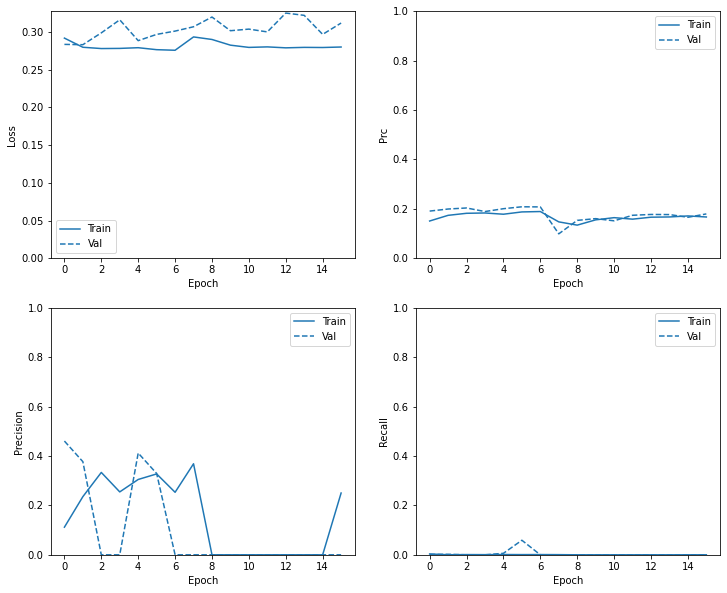

In [178]:
plot_metrics(history)

In [179]:
model.metrics_names

['loss',
 'tp',
 'fp',
 'tn',
 'fn',
 'accuracy',
 'precision',
 'recall',
 'auc',
 'prc']

## Calculate class weights

In [180]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.55
Weight for class 1: 5.59


PS: We use "Adam" optimiser since it's unaffected by the scaling here

In [181]:
#we change it from 50 to 100
EPOCHS = 100

In [182]:
weighted_model = build_model()
weighted_model.load_weights(initial_weights)

In [183]:
with comet_exp.train():
    weighted_history = weighted_model.fit(
    x=train_ds,
    epochs=EPOCHS,
    #callbacks=[stop_early],
    validation_data=val_ds,
    # class weights
    class_weight=class_weight)

Epoch 1/100
485/485 [==============================] - 11s 20ms/step - loss: 0.6488 - tp: 17729.0000 - fp: 115459.0000 - tn: 562715.0000 - fn: 48925.0000 - accuracy: 0.7793 - precision: 0.1331 - recall: 0.2660 - auc: 0.5731 - prc: 0.1154 - val_loss: 0.9440 - val_tp: 19439.0000 - val_fp: 133966.0000 - val_tn: 92092.0000 - val_fn: 2779.0000 - val_accuracy: 0.4492 - val_precision: 0.1267 - val_recall: 0.8749 - val_auc: 0.7213 - val_prc: 0.1809
Epoch 2/100
485/485 [==============================] - 8s 17ms/step - loss: 0.6312 - tp: 15490.0000 - fp: 86967.0000 - tn: 139091.0000 - fn: 6728.0000 - accuracy: 0.6226 - precision: 0.1512 - recall: 0.6972 - auc: 0.7034 - prc: 0.1731 - val_loss: 0.9295 - val_tp: 18822.0000 - val_fp: 121501.0000 - val_tn: 104557.0000 - val_fn: 3396.0000 - val_accuracy: 0.4969 - val_precision: 0.1341 - val_recall: 0.8472 - val_auc: 0.7261 - val_prc: 0.1918
Epoch 3/100
485/485 [==============================] - 8s 17ms/step - loss: 0.6227 - tp: 16125.0000 - fp: 89483.

485/485 [==============================] - 8s 17ms/step - loss: 0.6314 - tp: 15943.0000 - fp: 90428.0000 - tn: 135630.0000 - fn: 6275.0000 - accuracy: 0.6105 - precision: 0.1499 - recall: 0.7176 - auc: 0.6892 - prc: 0.1498 - val_loss: 0.7113 - val_tp: 14555.0000 - val_fp: 72691.0000 - val_tn: 153367.0000 - val_fn: 7663.0000 - val_accuracy: 0.6764 - val_precision: 0.1668 - val_recall: 0.6551 - val_auc: 0.7094 - val_prc: 0.1597
Epoch 20/100
485/485 [==============================] - 8s 17ms/step - loss: 0.6566 - tp: 16005.0000 - fp: 90126.0000 - tn: 135932.0000 - fn: 6213.0000 - accuracy: 0.6120 - precision: 0.1508 - recall: 0.7204 - auc: 0.7055 - prc: 0.1645 - val_loss: 0.7765 - val_tp: 20576.0000 - val_fp: 156672.0000 - val_tn: 69386.0000 - val_fn: 1642.0000 - val_accuracy: 0.3623 - val_precision: 0.1161 - val_recall: 0.9261 - val_auc: 0.6863 - val_prc: 0.1445
Epoch 21/100
485/485 [==============================] - 8s 17ms/step - loss: 0.6302 - tp: 15891.0000 - fp: 90468.0000 - tn: 135

485/485 [==============================] - 8s 16ms/step - loss: 0.6281 - tp: 16076.0000 - fp: 92271.0000 - tn: 133787.0000 - fn: 6142.0000 - accuracy: 0.6036 - precision: 0.1484 - recall: 0.7236 - auc: 0.7027 - prc: 0.1588 - val_loss: 0.6155 - val_tp: 14037.0000 - val_fp: 65557.0000 - val_tn: 160501.0000 - val_fn: 8181.0000 - val_accuracy: 0.7030 - val_precision: 0.1764 - val_recall: 0.6318 - val_auc: 0.7112 - val_prc: 0.1624
Epoch 38/100
485/485 [==============================] - 8s 17ms/step - loss: 0.6382 - tp: 17096.0000 - fp: 105722.0000 - tn: 120336.0000 - fn: 5122.0000 - accuracy: 0.5535 - precision: 0.1392 - recall: 0.7695 - auc: 0.6825 - prc: 0.1457 - val_loss: 0.7405 - val_tp: 20939.0000 - val_fp: 165249.0000 - val_tn: 60809.0000 - val_fn: 1279.0000 - val_accuracy: 0.3293 - val_precision: 0.1125 - val_recall: 0.9424 - val_auc: 0.6102 - val_prc: 0.1127
Epoch 39/100
485/485 [==============================] - 8s 16ms/step - loss: 0.6319 - tp: 17608.0000 - fp: 106858.0000 - tn: 1

485/485 [==============================] - 8s 17ms/step - loss: 0.6255 - tp: 16949.0000 - fp: 99338.0000 - tn: 126720.0000 - fn: 5269.0000 - accuracy: 0.5787 - precision: 0.1458 - recall: 0.7628 - auc: 0.7036 - prc: 0.1624 - val_loss: 0.7773 - val_tp: 20150.0000 - val_fp: 140605.0000 - val_tn: 85453.0000 - val_fn: 2068.0000 - val_accuracy: 0.4253 - val_precision: 0.1253 - val_recall: 0.9069 - val_auc: 0.7018 - val_prc: 0.1509
Epoch 56/100
485/485 [==============================] - 8s 17ms/step - loss: 0.6255 - tp: 17037.0000 - fp: 100385.0000 - tn: 125673.0000 - fn: 5181.0000 - accuracy: 0.5748 - precision: 0.1451 - recall: 0.7668 - auc: 0.7064 - prc: 0.1671 - val_loss: 0.6747 - val_tp: 18741.0000 - val_fp: 114436.0000 - val_tn: 111622.0000 - val_fn: 3477.0000 - val_accuracy: 0.5251 - val_precision: 0.1407 - val_recall: 0.8435 - val_auc: 0.7185 - val_prc: 0.1720
Epoch 57/100
485/485 [==============================] - 8s 17ms/step - loss: 0.6241 - tp: 16366.0000 - fp: 96313.0000 - tn: 1

485/485 [==============================] - 9s 18ms/step - loss: 0.7731 - tp: 16125.0000 - fp: 90515.0000 - tn: 135543.0000 - fn: 6093.0000 - accuracy: 0.6109 - precision: 0.1512 - recall: 0.7258 - auc: 0.6822 - prc: 0.1464 - val_loss: 0.5829 - val_tp: 4955.0000 - val_fp: 74402.0000 - val_tn: 151656.0000 - val_fn: 17263.0000 - val_accuracy: 0.6308 - val_precision: 0.0624 - val_recall: 0.2230 - val_auc: 0.5212 - val_prc: 0.0858
Epoch 74/100
485/485 [==============================] - 10s 20ms/step - loss: 0.7042 - tp: 14168.0000 - fp: 96251.0000 - tn: 129807.0000 - fn: 8050.0000 - accuracy: 0.5799 - precision: 0.1283 - recall: 0.6377 - auc: 0.6560 - prc: 0.1480 - val_loss: 0.5232 - val_tp: 16995.0000 - val_fp: 100701.0000 - val_tn: 125357.0000 - val_fn: 5223.0000 - val_accuracy: 0.5734 - val_precision: 0.1444 - val_recall: 0.7649 - val_auc: 0.7025 - val_prc: 0.1674
Epoch 75/100
485/485 [==============================] - 12s 24ms/step - loss: 0.6407 - tp: 16861.0000 - fp: 110316.0000 - tn:

Epoch 91/100
485/485 [==============================] - 9s 19ms/step - loss: 0.6376 - tp: 17097.0000 - fp: 104177.0000 - tn: 121881.0000 - fn: 5121.0000 - accuracy: 0.5598 - precision: 0.1410 - recall: 0.7695 - auc: 0.6723 - prc: 0.1397 - val_loss: 0.5308 - val_tp: 16982.0000 - val_fp: 93056.0000 - val_tn: 133002.0000 - val_fn: 5236.0000 - val_accuracy: 0.6041 - val_precision: 0.1543 - val_recall: 0.7643 - val_auc: 0.6920 - val_prc: 0.1474
Epoch 92/100
485/485 [==============================] - 9s 18ms/step - loss: 0.6473 - tp: 16045.0000 - fp: 98580.0000 - tn: 127478.0000 - fn: 6173.0000 - accuracy: 0.5781 - precision: 0.1400 - recall: 0.7222 - auc: 0.6772 - prc: 0.1466 - val_loss: 0.5460 - val_tp: 16231.0000 - val_fp: 91569.0000 - val_tn: 134489.0000 - val_fn: 5987.0000 - val_accuracy: 0.6071 - val_precision: 0.1506 - val_recall: 0.7305 - val_auc: 0.6825 - val_prc: 0.1433
Epoch 93/100
485/485 [==============================] - 9s 19ms/step - loss: 0.6456 - tp: 16922.0000 - fp: 108221

In [203]:
results = weighted_model.evaluate(val_ds)

for name, value in zip(weighted_model.metrics_names, results):
    print(name, ': ', value)
print()

485/485 [==============================] - 3s 6ms/step - loss: 0.6027 - tp: 17739.0000 - fp: 101449.0000 - tn: 124609.0000 - fn: 4479.0000 - accuracy: 0.5733 - precision: 0.1488 - recall: 0.7984 - auc: 0.6962 - prc: 0.1504
loss :  0.6026849150657654
tp :  17739.0
fp :  101449.0
tn :  124609.0
fn :  4479.0
accuracy :  0.5733457803726196
precision :  0.14883209764957428
recall :  0.798406720161438
auc :  0.6962170600891113
prc :  0.15040621161460876



In [204]:
y_proba_val = weighted_model.predict(val_ds, verbose=1)

485/485 [==============================] - 3s 6ms/step


In [205]:
y_proba_val = np.concatenate([y for y in y_proba_val], axis=0)

In [206]:
threshold = 0.5
y_pred_val = np.where(y_proba_val > threshold, 1,0)

In [207]:
y_pred_val.sum()

119188

In [208]:
val_y_true = np.concatenate([y for x, y in val_ds], axis=0)

In [209]:
val_y_true.sum()

22218

# Prepare for Comet Logs

In [191]:
#these will all get logged
params={'batch_size':BATCH_SIZE,
        'epochs':EPOCHS,
        'layer_num':7,
        'optimizer':'adam',
        'learning_rate':LEARNING_RATE
}

In [192]:
#will log metrics with the prefix 'test_'
# with experiment.test():
#     results = model.evaluate(x_test, y_test)
    
#     experiment.log_metrics(metrics)

In [210]:
# results = weighted_model.evaluate(test_ds)
# for name, value in zip(weighted_model.metrics_names, results):
#     print(name, ': ', value)

ValueError: in user code:

    File "C:\Users\alaed\anaconda3\envs\ift6758-conda-env\lib\site-packages\keras\engine\training.py", line 1366, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\alaed\anaconda3\envs\ift6758-conda-env\lib\site-packages\keras\engine\training.py", line 1356, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\alaed\anaconda3\envs\ift6758-conda-env\lib\site-packages\keras\engine\training.py", line 1349, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\alaed\anaconda3\envs\ift6758-conda-env\lib\site-packages\keras\engine\training.py", line 1303, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\alaed\anaconda3\envs\ift6758-conda-env\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\alaed\anaconda3\envs\ift6758-conda-env\lib\site-packages\keras\engine\input_spec.py", line 227, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_9" (type Sequential).
    
    Input 0 of layer "dense_51" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (16,)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(16,), dtype=float64)
      • training=False
      • mask=None


In [193]:
comet_exp.log_parameters(params)

In [194]:
weights_dir = "../ift6758/models/weights"
experiment = "Neural-Net-with-FE2"
predscore_val_dict={}

In [195]:
# import joblib

# predscore_val_dict[experiment]={}
# predscore_val_dict[experiment]['true_valid_label']=y_valid
# predscore_val_dict[experiment]['proba']=y_proba_val
# predscore_val_dict[experiment]['prediction']=y_pred_val

# ## Dumping model
# filename=f"{weights_dir}/{experiment}.pkl"
# filename
# joblib.dump(model,filename)

In [154]:
comet_exp.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/morph-e/milestone-2/7b31fdabd2264bacb15166b2be9f561e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [50]                        : (0.910345733165741, 0.9106639623641968)
COMET INFO:     auc [50]                             : (0.6643919944763184, 0.7489079236984253)
COMET INFO:     batch_accuracy [650]                 : (0.89599609375, 0.9130859375)
COMET INFO:     batch_auc [650]                      : (0.48242396116256714, 0.7782735824584961)
COMET INFO:     batch_fn [650]                       : (177.0, 22183.0)
COMET INFO:     batch_fp [650]                       : (0.0, 264.0)
COMET INFO:     batch_loss [650]                     : (0.25986507534980774, 0.43941688537597656)
COMET INFO:     batch_prc [650]                    

AttributeError: 'CPULoggingThread' object has no attribute 'isAlive'

## Plotting

              precision    recall  f1-score   support

           0       0.91      0.52      0.66    226058
           1       0.09      0.48      0.15     22218

    accuracy                           0.52    248276
   macro avg       0.50      0.50      0.41    248276
weighted avg       0.84      0.52      0.62    248276



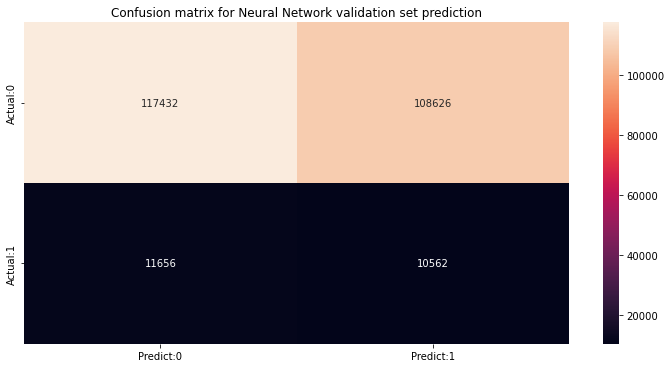

In [211]:
from ift6758.metrics import plot_metrics

plot_metrics.plotConfusion(val_y_true,y_pred_val, title='Confusion matrix for Neural Network validation set prediction')

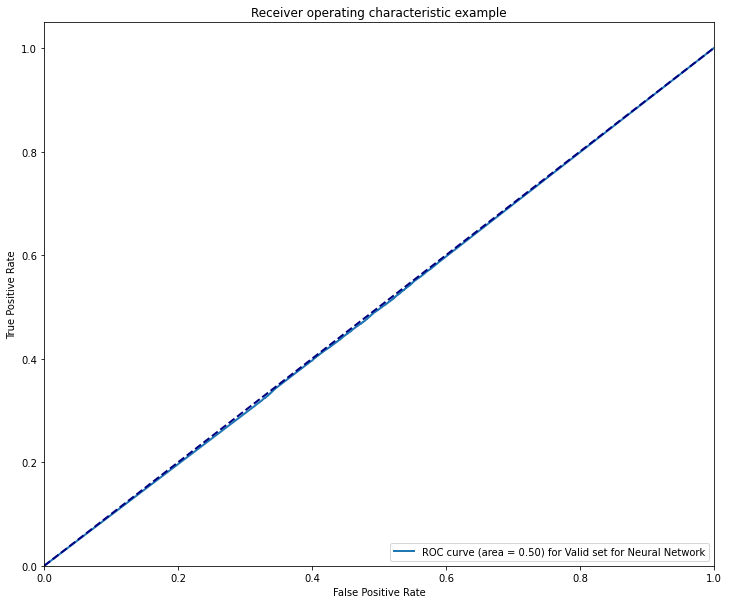

In [212]:
plot_metrics.plot_roc([val_y_true],[y_proba_val],["Valid set for Neural Network"])

ValueError: Bin edges must be unique: array([0.16973025, 0.16973025, 0.16973025, 0.16973025, 0.16973025,
       0.16973025, 0.16973025, 0.16973025, 0.16973025, 0.4247383 ,
       0.4732791 , 0.54518922, 0.62757581, 0.64358246, 0.6533007 ,
       0.6533007 , 0.6533007 , 0.6533007 , 0.6533007 , 0.6533007 ,
       0.6533007 ]).
You can drop duplicate edges by setting the 'duplicates' kwarg

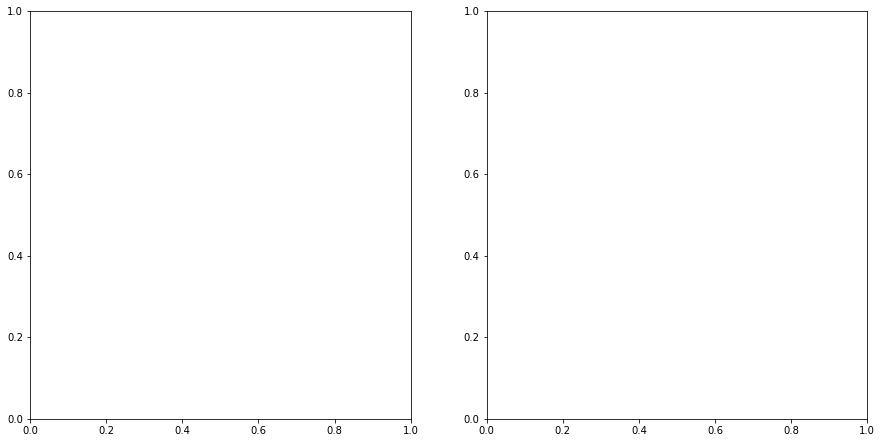

In [215]:
plot_metrics.plot_percentile([val_y_true],[y_proba_val],bin_width=5,plot_labels=["Valid set for Neural Network"])

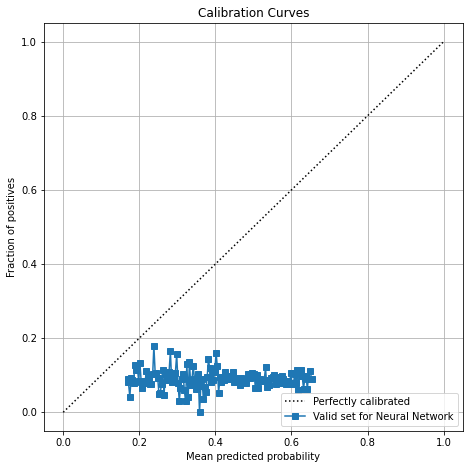

In [216]:
plot_metrics.plot_calibration([val_y_true],[y_proba_val],plot_labels=["Valid set for Neural Network"])